In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import time
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


torch.Size([3, 128, 128])


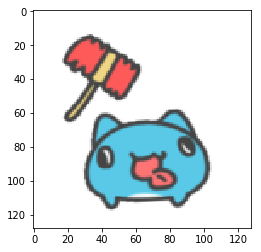

128 128


In [2]:
if not os.path.exists('./previews'):
    os.makedirs('./previews')
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
n_dim = 128
n_feature = 128
n_d_latent = 128
n_ch = 3
g_feature_map_b = 64
d_feature_map_b = 64

fold_dataset = datasets.ImageFolder('./kaboo', 
                       transform=transforms.Compose([
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomAffine(5, translate=(0.05,0.05), scale=(0.9,1.1), shear=2, resample=2, fillcolor=tuple([255]*n_ch)),
                           transforms.Resize([n_dim]*2, interpolation=2),
                           transforms.ToTensor(), # normalize to [0,1]
                           transforms.Normalize([0.5]*n_ch, [0.5]*n_ch) # [0,1] -> [-1,+1]
                       ]))
'''
fold_dataset = datasets.MNIST('./mnist_data', download=True, train=False, transform=transforms.Compose([
                           transforms.Pad(2), # 28 -> 32
                           transforms.ToTensor(), # normalize to [0,1]
                           transforms.Normalize([0.5]*n_ch, [0.5]*n_ch) # [0,1] -> [-1,+1]
                       ]))
'''
print(fold_dataset.__getitem__(100)[0].shape)
plt.imshow(np.squeeze(np.clip(np.array(fold_dataset.__getitem__(100)[0]).transpose(1,2,0)*127.5+127.5,0,255).astype(np.uint8)))
plt.show()
data_loader = torch.utils.data.DataLoader(
        fold_dataset,
        batch_size=batch_size, shuffle=True, num_workers=4)
print(n_dim, n_feature)
def inf_data_gen():
    while True:
        for data, label in data_loader:
            yield data
gen = inf_data_gen()

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)

def relaxed_orthogonal_reg(model, device, reg=1e-4):
    orth_loss = torch.ones(1, requires_grad=True, device=device)
    for name, param in model.named_parameters():
        if 'bias' not in name:
            param_flat = param.view(param.size(0), -1)
            sym = torch.mm(param_flat, torch.t(param_flat))
            mask= 1 - torch.eye(param.size(0), device=device)
            orth_loss = orth_loss + ((sym*mask)**2).sum()
    return reg * orth_loss

def one_hot(ids, n_class):
    if len(ids.size())==2:
        return ids
    ohe = torch.FloatTensor(ids.size(0), n_class)
    ids = ids.view(-1,1)
    ohe.zero_()
    ohe.scatter_(1, ids, 1)
    return ohe

class ConvolutioBlock(nn.Module):
    def __init__(self, in_ch, out_ch, norm=True, down=False, relu=True, leaky=False):
        super(ConvolutioBlock, self).__init__()
        
        conv_block = []
        conv_block += [nn.Conv2d(in_ch, out_ch, 3, stride=2 if down else 1, padding=1, bias=False)]
        if norm:
            conv_block += [nn.InstanceNorm2d(out_ch)]
        if relu:
            conv_block += [ nn.LeakyReLU(0.2, inplace=True) if leaky else nn.ReLU(inplace=True) ]

        self.conv_block = nn.Sequential(*conv_block)
        self.conv_block.apply(weights_init)
    def forward(self, x):
        return self.conv_block(x)

# ref SRResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_ch):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1, bias=False),
                        nn.InstanceNorm2d(in_ch),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1, bias=False),
                        nn.InstanceNorm2d(in_ch)  
                     ]

        self.conv_block = nn.Sequential(*conv_block)
        self.conv_block.apply(weights_init)

    def forward(self, x):
        return x + self.conv_block(x)

class UpConvolution(nn.Module):
    def __init__(self, in_ch, out_ch, norm=True, relu=True, leaky=False):
        super(UpConvolution, self).__init__()
        
        conv_block = [nn.PixelShuffle(2)]
        conv_block += [nn.Conv2d(in_ch//4, out_ch, 3, stride=1, padding=1, bias=False)]
        if norm:
            conv_block += [nn.InstanceNorm2d(out_ch)]
        if relu:
            conv_block += [ nn.LeakyReLU(0.2, inplace=True) if leaky else nn.ReLU(inplace=True) ]

        self.conv_block = nn.Sequential(*conv_block)
        self.conv_block.apply(weights_init)

    def forward(self, x):
        return self.conv_block(x)

class C(nn.Module):
    def __init__(self, N_DIM=32, N_CH=3, BASE_FEATURE_N=32, N_BOTTLENECK=128):
        super(C, self).__init__()
        self.n_dim = N_DIM
        self.n_ch = N_CH
        self.base_f = BASE_FEATURE_N
        self.n_bottleneck = N_BOTTLENECK
        self.head_conv = nn.Conv2d(self.n_ch, self.base_f, 3, stride=1, padding=1, bias=False)
        weights_init(self.head_conv)
        self.convs1 = nn.Sequential(*[
            ConvolutioBlock( self.base_f, self.base_f,   norm=True, down=True, relu=True, leaky=True ), # /2
            ConvolutioBlock( self.base_f, self.base_f*2, norm=True, down=True, relu=True, leaky=True ), # /4
            ConvolutioBlock( self.base_f*2, self.base_f*4, norm=True, down=True, relu=True, leaky=True ), # /8
            ConvolutioBlock( self.base_f*4, self.base_f*8, norm=True, down=True, relu=True, leaky=True ), # /16
            ConvolutioBlock( self.base_f*8, self.base_f*8, norm=True, down=True, relu=True, leaky=True ), # /32
        ])
        self.fc1 = nn.Linear(self.base_f*8*(self.n_dim//32)**2, self.n_bottleneck, bias=False)
        self.fc2 = nn.Linear(self.n_bottleneck, self.base_f*8*(self.n_dim//32)**2, bias=False)
        weights_init(self.fc1)
        weights_init(self.fc2)
        self.convs2 = nn.Sequential(*[
            UpConvolution(self.base_f*8, self.base_f*8, norm=True, relu=True, leaky=True), # 2x
            UpConvolution(self.base_f*8, self.base_f*4, norm=True, relu=True, leaky=True), # 4x
            UpConvolution(self.base_f*4, self.base_f*2, norm=True, relu=True, leaky=True), # 8x
            UpConvolution(self.base_f*2, self.base_f, norm=True, relu=True, leaky=True), # 16x
            UpConvolution(self.base_f, self.base_f, norm=True, relu=True, leaky=True), # 32x
        ])
        self.tail_conv = nn.Conv2d(self.base_f, self.n_ch, 3, stride=1, padding=1, bias=False)
        weights_init(self.tail_conv)
        
    def forward(self, x):
        
        o = x
        
        x = self.head_conv(x)
        x = self.convs1(x)
        x = x.view(x.size(0), self.base_f*8*(self.n_dim//32)**2)
        x = self.fc1(x)
        
        x = self.fc2(x)
        x = x.view(x.size(0), self.base_f*8, self.n_dim//32, self.n_dim//32)
        x = self.convs2(x)
        
        x = self.tail_conv (x)
        x = torch.tanh(x)
        return torch.abs(x-o).mean()

class G(nn.Module):
    def __init__(self, N_DIM, N_FEATURE, N_CH, BASE_FEATURE_N=32):
        super(G, self).__init__()
        self.n_dim = N_DIM
        self.n_ch  = N_CH
        self.base_f = BASE_FEATURE_N
        self.n_feature = N_FEATURE
        self.latent_map = nn.Linear(self.n_feature, self.base_f*8*((self.n_dim//32)**2)) 
        weights_init(self.latent_map)
        self.convs = nn.Sequential(*[
            ResidualBlock(self.base_f*8),
            UpConvolution(self.base_f*8, self.base_f*4, norm=True, relu=True), # 2x
            UpConvolution(self.base_f*4, self.base_f*4, norm=True, relu=True), # 4x
            UpConvolution(self.base_f*4, self.base_f*2, norm=True, relu=True), # 8x
            UpConvolution(self.base_f*2, self.base_f*2, norm=True, relu=True), # 16x
            UpConvolution(self.base_f*2, self.base_f, norm=True, relu=True),   # 32x
        ])
        self.tail_conv = nn.Conv2d(self.base_f, self.n_ch, 3, stride=1, padding=1, bias=False)
        weights_init(self.tail_conv)
        
    def forward(self, x):
        x = self.latent_map(x)
        x = x.view(x.size(0), self.base_f*8, self.n_dim//32, self.n_dim//32)
        x = self.convs(x)
        x = self.tail_conv (x)
        x = torch.tanh(x)
        return x

In [4]:
def plot2dir(directory='./previews', imgs=None, iter_n=0):
    imgs = np.clip(np.round((np.concatenate(tuple(imgs.transpose(0,2,3,1)), axis=0)+1)*127.5), 0, 255).astype(np.uint8) # (?, 28, 28)
    cv2.imwrite('{}/{:08d}.jpg'.format(directory, iter_n), np.squeeze(imgs[...,::-1])) # RGB->BGR
    

In [ ]:
G_net = G(n_dim, n_feature, n_ch, g_feature_map_b).to(device)
C_net = C(n_dim, n_ch, d_feature_map_b, n_d_latent).to(device)
opt_C = optim.Adam(C_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_G = optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
from tqdm import tqdm_notebook

iterations = 50000
preview_iter = 200
# max_preview_imgs = 5
d_iter = 1
std = 1.0
min_k = 0.001
k = torch.FloatTensor([0]).to(device)
lambda_k = torch.FloatTensor([0.001]).to(device) 
gamma = torch.FloatTensor([0.75]).to(device) 

for ite in tqdm_notebook(range(1, iterations+1)):
    start_train_ts = time.time()
    # train D:
    G_net.eval()
    C_net.train()
    d_loss_mean = []
    g_loss_mean = 0.0
    for _ in range(d_iter):
        real = next(gen)
        real = real.to(device)
        sample = torch.randn(real.size(0), n_feature, device=device).clamp(-2,2) * std
        fake   = G_net(sample).detach() # not to touch G_net
        d_loss_real = C_net(real)
        d_loss_fake = C_net(fake)
        d_loss_fake = -k.detach() * d_loss_fake
        d_loss = d_loss_real + d_loss_fake
        opt_C.zero_grad()
        d_loss.backward()
        opt_C.step()
        d_loss_mean.append(d_loss.item())
    d_loss_mean = np.mean(d_loss_mean)
    D_update_ts = time.time()
    # train G:
    real = next(gen)
    real = real.to(device)
    G_net.train()
    C_net.eval()
    sample = torch.randn(real.size(0), n_feature, device=device).clamp(-2,2) * std
    generated = G_net(sample)
    g_loss = C_net(generated) + relaxed_orthogonal_reg(G_net, device)
    opt_G.zero_grad()
    opt_C.zero_grad()
    g_loss.backward()
    opt_G.step()
    g_loss = g_loss.item()
    G_update_ts = time.time()
    k_delta = gamma.detach()*d_loss_real-g_loss
    M_global = (d_loss_real + torch.abs(k_delta)).item()
    k = (k + lambda_k.detach()*k_delta).clamp(min=min_k, max=1)
    if ite%preview_iter==0:
        print('[{}/{}] G:{:.4f}, D:{:.4f}, M:{:4f}, k:{:4f} -- elapsed_G: {:.4f}s -- elapsed_D: {:.4f}s'.format(ite, iterations, g_loss, d_loss_mean, M_global, k.item(), (G_update_ts-D_update_ts), (D_update_ts-start_train_ts) ))
        
        plot2dir('./previews', generated[:8].detach().cpu().numpy(), ite)
        torch.save(G_net.state_dict(), './checkpoints/iter-{:d}-G.ckpt'.format(ite))
        torch.save(C_net.state_dict(), './checkpoints/iter-{:d}-D.ckpt'.format(ite))

[200/50000] G:0.0679, D:0.1176, M:0.139147, k:0.014331 -- elapsed_G: 0.3942s -- elapsed_D: 0.5355s
[400/50000] G:0.0451, D:0.0874, M:0.108794, k:0.019943 -- elapsed_G: 0.3105s -- elapsed_D: 0.3391s
[600/50000] G:0.0347, D:0.0710, M:0.090657, k:0.022877 -- elapsed_G: 0.3108s -- elapsed_D: 0.3392s
[800/50000] G:0.0519, D:0.0766, M:0.084198, k:0.026661 -- elapsed_G: 0.3109s -- elapsed_D: 0.3372s
[1000/50000] G:0.0303, D:0.0674, M:0.089180, k:0.029083 -- elapsed_G: 0.3106s -- elapsed_D: 0.3348s
[1200/50000] G:0.0305, D:0.0709, M:0.095300, k:0.032080 -- elapsed_G: 0.3096s -- elapsed_D: 0.3373s
[1400/50000] G:0.0239, D:0.0499, M:0.064713, k:0.035656 -- elapsed_G: 0.3112s -- elapsed_D: 0.3386s
[1600/50000] G:0.0237, D:0.0625, M:0.087062, k:0.038950 -- elapsed_G: 0.3103s -- elapsed_D: 0.3396s
[1800/50000] G:0.0570, D:0.0496, M:0.069841, k:0.041311 -- elapsed_G: 0.3129s -- elapsed_D: 0.3481s
[2000/50000] G:0.0342, D:0.0604, M:0.073476, k:0.043306 -- elapsed_G: 0.3111s -- elapsed_D: 0.4014s
